#### For volcano plot (pre vs. post tratment in drug resistant sarcoma patients) in Figure 4

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
from matplotlib import colors
import os
from numpy import ma
import seaborn as sns
%matplotlib inline
from scipy import stats
from scipy.stats import zscore
from sklearn.decomposition import PCA
from natsort import natsorted
import ipywidgets
from glob import glob
import logging
import sys
import pingouin as pg
from statsmodels.stats.weightstats import ttest_ind
from statistics import mean
from scipy.stats import t

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure4 data_SenstiveResistant')

In [3]:
# import data from github

dfSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/Protein_pVals_Final_WithMetaData.xlsx', sheet_name='Sheet1')

In [4]:
parser = 'group'

In [20]:
# Filter for the analysis

df = dfSarcoma
dataTypeFilter = 'NormalizedIntensity_Log2'
    
df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("dataType == @dataTypeFilter")

df = df.query("timing != 'Control' and sensitivity == 'R'") # resitant

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column specifying the dataset
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfProtein = df
dfProtein.head()

,age,dataset,timing,sample,patient,race,group,cancer,dataType,cancerType,gender,sensitivity,protAcc,area
22,50-59,sarcoma,Post,BNV.R.Post,BNV,WHITE,R.Post,c,NormalizedIntensity_Log2,PS/MFH,M,R,A0A075B6H7,0.777
25,50-59,sarcoma,Pre,BPA.R.Pre,BPA,WHITE,R.Pre,c,NormalizedIntensity_Log2,LS,M,R,A0A075B6H7,0.646
38,60-69,sarcoma,Post,BUF.R.Post,BUF,WHITE,R.Post,c,NormalizedIntensity_Log2,PS/MFH,M,R,A0A075B6H7,-0.105
39,60-69,sarcoma,Pre,BUF.R.Pre,BUF,WHITE,R.Pre,c,NormalizedIntensity_Log2,PS/MFH,M,R,A0A075B6H7,0.330
62,70-79,sarcoma,Post,CFM.R.Post,CFM,WHITE,R.Post,c,NormalizedIntensity_Log2,PS/MFH,F,R,A0A075B6H7,-0.541


#### annotate merged long/tidy data with uniprot IDs (or other metadata)

In [23]:
# make dfUniprot for annotation, this excel file is on the associated GitHub page

dfUniprot = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/uniprot-download_true_fields_accession_2Creviewed_2Cid_2Cprotein_nam-2023.03.17-19.33.16.44.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)
dfUniprot

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,protAcc,Reviewed,Protein names,geneNamePrimary
0,A0A075B6G3,unreviewed,Dystrophin,DMD
1,A0A087WV00,unreviewed,Diacylglycerol kinase (DAG kinase) (EC 2.7.1.107),DGKI
2,A0A087WZT3,unreviewed,BOLA2-SMG1P6 readthrough,BOLA2-SMG1P6
3,A0A087X1C5,reviewed,Putative cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7
4,A0A0A0MQU7,unreviewed,HNF1 homeobox A,HNF1A
...,...,...,...,...
81786,X6RLU5,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81787,X6RLV5,unreviewed,DEAD-box helicase 5,DDX5
81788,X6RLY7,unreviewed,Calcium voltage-gated channel auxiliary subuni...,CACNA2D4
81789,X6RM00,unreviewed,ELKS/RAB6-interacting/CAST family member 1,ERC1


In [24]:
# annotate uniprot info
dfMerged = dfProtein.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfMerged.columns
numCols = dfMerged._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfMerged['area'] = dfMerged['area'].astype(float)

In [25]:
# remove Remove 'crapome' proteins

crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']

dfMerged = dfMerged.loc[~dfMerged['geneNamePrimary'].str.contains('|'.join(crapome))]

In [26]:
# count protein IDs

dfTemp = dfMerged

nSamplesFilter = 10
nSamplesControlOnlyFilter = 0
    
#drop 0 values
dfTemp.dropna(subset = ['area'], inplace = True)

# count
dfTemp['nSamples'] = dfTemp.groupby('protAcc')['protAcc'].transform('count')
nSamplesControlOnly = dfTemp.query('cancer == "n"').groupby('protAcc')['protAcc'].agg('count').to_frame()
nSamplesControlOnly.rename(columns = {'protAcc' : 'nSamplesControlOnly'}, inplace = True)
dfTemp = dfTemp.join(nSamplesControlOnly, on = 'protAcc')
dfTemp['nSamplesControlOnly'] = dfTemp['nSamplesControlOnly'].fillna(0)

# filter by N detections
dfTemp = dfTemp.query('nSamples >= @nSamplesFilter')
dfTemp = dfTemp.query('nSamplesControlOnly >= @nSamplesControlOnlyFilter')

dfFiltered = dfTemp

In [27]:
# find and select data/feature columns

totalCols = dfFiltered.columns
numCols = dfFiltered._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

# pivot 
dfStatsPre = dfFiltered.pivot_table(
    values = 'area',
    index = [parser,'sample'],
    columns = ['geneNamePrimary'],
).reset_index().rename_axis(None, axis=1)
dfStatsPre.set_index(parser, inplace = True)

dfStatsPre.reset_index(inplace = True)
sampleNames = dfStatsPre['sample']
dfStatsPre = dfStatsPre.drop(columns = ['sample'])

# impute nan to min value in column

for col in dfStatsPre.columns:
    dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_55675/3059717704.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dfStatsPre[col].fillna(value = dfStatsPre[col].min(), inplace = True)


In [28]:
# melt
dfStatsPre = dfStatsPre.melt(
    id_vars = parser,
    value_name = 'area',
    var_name = 'geneNamePrimary',
)

In [29]:
# setup groups

RPre = dfStatsPre.query('group == "R.Post"')
SPre = dfStatsPre.query('group == "R.Pre"')

In [30]:
# make dfStats with pvals / qvals and other stats

colName = 'geneNamePrimary'
valueCol = 'area'

# make a list of all genes
allGenes = dfStatsPre['geneNamePrimary'].unique()

# to make new dfStats
dfStats = pd.DataFrame()
geneNamePrimaryList = []
group1List = []
group2List = []
oneGroupDetectionList = []
group2DetectionOnlyList = []
group1MeanList = []
group2MeanList = []
pvalScipyList = []
pvalPingouinList = []
pvalstatsmodelList = []

for i in allGenes:
    group1 = RPre.query("{0} == '{1}'".format(colName, i))
    group2 = SPre.query("{0} == '{1}'".format(colName, i))
    geneNamePrimaryList.append(i)

    group1List.append(group1)
    group2List.append(group2)
    
    if len(group1) < 2 or len(group2) < 2:
        if len(group1) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup1')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        elif len(group2) < 3:
            oneGroupDetectionList.append('DetectedOnceOrLessInGroup2')
            manualPvalList.append('')
            pvalScipyList.append('')
            group1MeanList.append('')
            group2MeanList.append('')
        continue
    else:
        oneGroupDetectionList.append('')
        
        mean1, mean2 = mean(group1[valueCol]), mean(group2[valueCol]) # calculate means
        group1MeanList.append(mean1)
        group2MeanList.append(mean2)

        # scipy t-test
        tstat, p = stats.ttest_ind(group1[valueCol], group2[valueCol], equal_var=False)
        pvalScipyList.append(p)
        display(p)

dfStats['geneNamePrimary'] = geneNamePrimaryList
dfStats['RPre'] = group1List
dfStats['SPre'] = group2List
dfStats['meanRPre']= group1MeanList
dfStats['meanSPre']= group2MeanList
dfStats['oneGroupDetection'] = oneGroupDetectionList
dfStats['pvalScipy'] = pvalScipyList

# define direction change
dfStats['directionChange'] = np.where((dfStats['meanRPre'] > dfStats['meanSPre']), 'up', 'down')
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup1', 'down', dfStats['directionChange'])
dfStats['directionChange'] = np.where(dfStats['oneGroupDetection'] == 'DetectedOnceOrLessInGroup2', 'up', dfStats['directionChange'])

0.30827515081130163

0.8789871076581548

0.5875993763654768

0.4514604267804285

0.8615394153014159

0.6973887703965834

0.790975075907685

0.6309355227697586

0.5546849553947387

0.6403076291862096

0.4536257839259241

0.8262164914820758

0.0762081749100992

0.5555359909784685

0.3270107502081234

0.9968013471611505

0.8784341815806658

0.32283163664187786

0.7134362897747145

0.8355346574564938

0.769207344350407

0.6336209121966231

0.9517390293954604

0.5465836690183139

0.2365061669265165

0.43196399237524385

0.6099556738433168

0.8602027452594385

0.3325106834867919

0.6650138836121786

0.6686945603752315

0.8472538718413035

0.39071842863670014

0.5370235821024538

0.6395520238931365

0.38887989099363696

0.9138377060544851

0.10780338339448169

0.9185546574472554

0.19410723061207857

0.3187152956489843

0.4314118681637551

0.39062878984616956

0.39883594638662323

0.5475162404162466

0.43322471433647103

0.9942857860120577

0.6499083350253883

0.8162298046401548

0.9909561207635799

0.6544396841110338

0.6129859769336828

0.2821843837336888

0.8366208378351311

0.3025972750656736

0.334109911844069

0.48039746884950496

0.47707415731107117

0.5509132015893324

0.982544052560534

0.32058930800732527

0.22402766446251082

0.8361368350057771

0.7018112894167636

0.586173026297683

0.1043585594711082

0.3121823746209085

0.7779739036908407

0.909411747985657

0.9568310266233755

0.7231529720556565

0.6150797659922511

0.7924049864563347

0.505391294331085

0.860890573657914

0.6289465560077353

0.18561753163897296

0.8294506148645281

0.9068246445634575

0.3366215294408368

0.09286641923803841

0.9274231640202142

0.4891313027228088

0.9881540451573747

0.3432507838534381

0.7108139223343029

0.34369316409817574

0.25615127251645137

0.8890349903250971

0.751715838536489

0.953964469704609

0.11255383591135591

0.8746238015764063

0.6577849884538451

0.7458877905904793

0.7687413123970137

0.5220596678146345

0.5037356146956777

0.9124501041143847

0.39334410807633136

0.7994144367125466

0.23358860477786375

0.8752467321180691

0.62476069941843

0.8450132375019249

0.9714329619759726

0.6773041307465479

0.9201950212010672

0.8804583646341749

0.6929782013431904

0.8912560697565365

0.998016275699992

0.6931572766062535

0.4203867193790898

0.776557855588394

0.34259554581091844

0.6654485460135653

0.22338474056723612

0.8740533278764033

0.31570961267607445

0.9145906039361924

0.4155525468911998

0.32885548680118293

0.865039836780107

0.18437615584344957

0.7090673814231991

0.8144301945979189

0.704452820401853

0.7151347223404252

0.6414036384379623

0.893834827485411

0.7929168706909533

0.6259868429151523

0.6789359896529061

0.8424091403587013

0.7200924586831094

0.8711972226487099

0.869775446980175

0.6453406820199126

0.5814249420530179

0.6217722908371622

0.6899535454995045

0.3467663493507124

0.7760599678401776

0.704663852751589

0.7395786373860594

0.8149877653966442

0.7370853525067145

0.8320982181381941

0.5136250946777801

0.37478658710361257

0.3414218362967527

0.8790900161130197

0.6742213292120505

0.1907047097014966

0.635833974518043

0.9501023755433441

0.7329460907777086

0.719148399034995

0.8809353759677079

0.7160417721197604

0.8676239197016705

0.8262409163824775

0.499834423017247

0.3156784271248936

0.4477486385495557

0.5208120286815836

0.8574587009557634

0.8836095183827194

0.35055211907148165

0.608432766517566

0.9208770266197508

0.5480786500196589

0.999828229379027

0.6630773458267128

0.8614243501568678

0.6074268732731862

0.3881760526813164

0.17754405300975265

0.5080213391317376

0.41784838793708257

0.9994284343067494

0.9510084183729941

0.9404353396317116

0.7730245097876443

0.47134071673155276

0.6546101274353848

0.6504594417960443

0.582065502568551

0.8144065972717647

0.35376501589892717

0.6185551219398214

0.5358037943253791

0.2683489212852129

0.4416503527707629

0.784745065617377

0.937445414195538

0.6131842924803463

0.6596752814347385

0.8527968413824198

0.41368041472238104

0.6513059607687416

0.8890355653220648

0.8758906268538564

0.6290447706731483

0.4416891513697032

0.3689523958415971

0.8894648746600136

0.3855097610621542

0.2748998769331866

0.3804144407616544

0.9927438537280473

0.3197666907559897

0.32657735211743877

0.20092855528585962

0.4873240210999612

0.9471619872400795

0.5119385122390188

0.536040365330415

0.8804541942636465

0.1880095443750882

0.566426516964261

0.3960339017589386

0.24486225518707172

0.8848218887543793

0.923019991227594

0.3742680448021892

0.8710774135481929

0.8658364156940637

0.22574084947200584

0.9913692365293356

0.4141506293599735

0.9958436975011364

0.9578529567792253

0.5042725683091192

0.5030692340258204

0.5440439780383348

0.6136436260632596

0.351116836268082

0.5998496655748414

0.6023309920573108

0.9719578288277908

0.7276258423444002

0.5494705130341744

0.8407170606667123

0.40147186460451356

0.28190692905367537

0.5712218130785469

0.5977225947049234

0.20868956532594063

0.5268935127407417

0.3561137297935216

0.8801092963807271

0.20120954842318392

0.6409196740945913

0.3759051789535589

0.31986431194158027

0.675932385694034

0.6156992935531518

0.2644705420884273

0.7201508469261189

0.9366370268997382

0.7693830423005339

0.9842575102573674

0.6070892853657381

0.8577274995622232

0.8123032028888965

0.5468237580650723

0.7083831919550401

0.8209724027717421

0.8649228233059654

0.4280698614930404

0.3644938769720645

0.9235370897669091

0.6628657641451694

0.5241962880814214

0.48937241519117936

0.797490348885074

0.9892909711356679

0.7771412456389268

0.946516155415021

0.6511628255546451

0.6889835540245164

0.8028931252721613

0.7837786171622098

0.3849358877879212

0.3223127912425733

0.804391509435686

0.8132584623565413

0.7822014930587806

0.6648099579640183

0.6634368384243363

0.46824797788730466

0.5851955188652552

0.5138149137762275

0.6072385515293364

0.7539596739599895

0.8510938427702492

0.9666014200360381

0.36065641401911996

0.4154953257390641

0.17238099915896227

0.329101736954321

0.929966489370118

0.9002424396093665

0.25534517439794635

0.560028490265186

0.4022148176119942

0.8664366888354964

0.9384681710527645

0.6347046927551625

0.5145218858546448

0.3680851696548858

0.6505025273388586

0.6129962534907079

0.5408970457351222

0.7424463240435921

0.7474687541250641

0.42340813203456484

0.6296217422411838

0.6256578246200726

0.2648417132725524

0.9340995203064827

0.46889301159422836

0.6344936253176364

0.29279932562546446

0.5554769431517043

0.2654787918694731

0.675996106497111

0.923739022129428

0.6702188575067292

0.5507521996319104

0.9211949871607064

0.8375860920405176

0.5357376816059263

0.6417049596986462

0.7968168755901843

0.6999970975181513

0.9207000392349898

0.7141593280362977

0.4744847112808477

0.5128276030858139

0.7109393105873185

0.27024850756034124

0.22762530501691317

0.38900047198715504

0.565426642687032

0.6839918969660321

0.823412193777855

0.9560709996014578

0.590044707781729

0.21748313715501846

0.30320259562803054

0.5660801549206942

0.9196803387761627

0.3799105050217163

0.5865514430158624

0.7886734689013598

0.3536486798197541

0.5967622869896319

0.8168305478100346

0.6530871664391587

0.6582603642875695

0.46626908597940275

0.7961499015708525

0.3501949016841712

0.13084151975743888

0.9340251636418996

0.2367485421641006

0.4802336445329136

0.9750611349412724

0.5466994891752

0.9984085584265875

0.8950956620696463

0.7581084803351117

0.9950208569862364

0.4844361444636487

0.8471048894946975

0.8724926066517339

0.9534782331065892

0.8167102520306444

0.7184365789068214

0.8261252673139844

0.25234403305198727

0.19458711941171986

0.9645072300018911

0.6193736975339421

0.9913533877080923

0.8226331996948197

0.7748555332161104

0.4757388518037502

0.8752096581374996

0.6634348859700134

0.7120912153821994

0.5238853311960352

0.31942644261435893

0.47595446498898375

0.6139273339467117

0.6806217050172809

0.9191945519786034

0.5334321049368771

0.8911395636078234

0.20060561853001435

0.9420741325304327

0.7178753916387188

0.8464030579940498

0.7017966199178775

0.7641721246399135

0.42955440671764944

0.8720816446138249

0.6668034891258859

0.4789840425473473

0.44184569423702946

0.521278909653405

0.39407621553375705

0.7415687073021753

0.8600374580637483

0.8062057211325367

0.6433317954830438

0.5096780142194604

0.520557058761193

0.8631369660610274

0.8573227881072754

0.9811631394414556

0.8807158530268303

0.6890570723395743

0.7155715490899344

0.4139513553996912

0.7464574464960678

0.165045386094656

0.37234654325385463

0.4944191384249357

0.8975142480285383

0.931615648425453

0.8481150487883888

0.22137750380205598

0.49127508229269934

0.8112783772687948

0.6593267017742201

0.25258482982330643

0.5450835770802152

0.5448440088665503

0.7401771954375933

0.8482274566481858

0.6627343693253454

0.1215780553884272

0.7491170830194923

0.5697745438320987

0.4274293158295791

0.9841774113663186

0.5360354840188801

0.4991193248416086

0.2446154671552365

0.39053976276581115

0.8472888027565019

0.8911227857728062

0.7325355637782949

0.41385979689562946

0.6382515791123351

0.7362077853306116

0.6261029011336244

0.5825989206849119

0.5745222272521627

0.8483201001016489

0.9110055364569503

0.7237109225684859

0.6063737523757816

0.7029525748611535

0.9710994303014739

0.944559579769422

0.7736368565359919

0.8007681182651626

0.37841188170377604

0.957950743953636

0.2844974411173236

0.874586705562523

0.1756725275129732

0.7006563399915243

0.9327368841299334

0.7088799051995684

0.14030548757752623

0.6259366390952613

0.2521499954962805

0.9305073936387405

0.5846777842803954

0.7932212893524391

0.79834410410899

0.6043022923180652

0.4946398827257019

0.7612183248179542

0.4493779857455016

0.828748491008077

0.7481932844374608

0.6446541388961926

0.0704723759777263

0.6059378671325593

0.8906373581750773

0.8370093887835272

0.8765970619082404

0.3258187422134501

0.40943125842929917

0.6205507447762089

0.0788478428313506

0.9481988328135382

0.328020718456025

0.40269813857221004

0.9970154528452597

0.3026204530751798

0.6627237600884246

0.8339567991983332

0.8443903894177627

0.9857739803250871

0.11658583468114349

0.713032719474418

0.5616178106127037

0.789576565283193

0.3675627386524044

0.37406359000595235

0.9431149483202137

0.7556409365984159

0.9761517629118229

0.7032712587166309

0.6606727250262834

0.425687749807499

0.6016032091453445

0.15970661190130306

0.8677818701231472

0.8447628377861288

0.4533364780459421

0.5202394606778515

0.35035747289494024

0.31467684971424587

0.13337215549780923

0.9782322881886005

0.781014579175197

0.48690126426478564

0.4054705600434715

0.7777715405257086

0.04070233730945006

0.8709967431334201

0.6072045492980284

0.893602223773109

0.5281008757367123

0.8203317835930695

0.6829329757211029

0.4878099156599719

0.8570207463239521

0.6679865640548703

0.4823534723585142

0.4891413124555889

0.5472642970896402

0.3648265839086313

0.3151773318417585

0.522733387458731

0.8143244464882167

0.9562259051512317

0.2142756870134952

0.8205385581704775

0.9040134301709659

0.504005255373004

0.4039288356667855

0.843117159973185

0.8373774488297294

0.4741067390512588

0.5255049871518305

0.8339591296802907

0.8627483611208875

0.44536061204974

0.3453578978872083

0.9591199494445177

0.38428424861545185

0.6482244963791413

0.7797233816551687

0.8293300838369143

0.5761250345144067

0.7169435429246893

0.5249611586966066

0.3624643477407494

0.43720658205269247

0.73335836290047

0.5807320217782139

0.23136915605538408

0.3061056560342327

0.5796374370342392

0.6374998082531067

0.21251685577323606

0.7545599914867571

0.6709512034453219

0.883596029827246

0.834068413312867

0.964281532787911

0.8143189008539808

0.6817330418424281

0.8900046776311712

0.6098210731041984

0.5307835902935469

0.35476621583275836

0.5006116679847186

0.9681927344698072

0.9241179345444197

0.49670069491458746

0.6086665477196208

0.6300137084806767

0.4175828637313871

0.8555144987512125

0.585374662560413

0.7849832491513572

0.06137462567198024

0.9303679092602098

0.4852963776283814

0.930139997013866

0.6964117280805082

0.698081572758608

0.962407569050324

0.776861100877233

0.27778743781719895

0.9294650679924368

0.6324339297852066

0.8367809570014026

0.826782798326847

0.4629186243161785

0.43227136053253534

0.14831652533277134

0.7536613403416311

0.5105266369872188

0.6184354107486074

0.6740432959807849

0.514374425668098

0.7733111114184005

0.8534232289826683

0.8513105049125825

0.7337362707650769

0.6984629831019324

0.7894025148869339

0.8121806672263918

0.9312077764830875

0.12567478687571773

0.9984353121579566

0.834886728710916

0.9031324177041766

0.9418399515647113

0.7197305207005769

0.9481835378881985

0.5200114748318192

0.45541976349128643

0.8056394601102186

0.4470483387125135

0.5088272629993125

0.6533236185025371

0.1507245051165578

0.17723614190014103

0.6380000018175098

0.9326938339284784

0.8084777929153726

0.4796143683660361

0.6550471195214542

0.8600061387342498

0.7946486560824585

0.4582945649142457

0.7219452050138295

0.5183969737662235

0.6560598245941363

0.15857705295621224

0.35283415173815935

0.8318135665090813

0.2889021290607161

0.2355790182813498

0.2681615356649483

0.038616690162154854

0.1915660876247958

0.7887515714464568

0.6661708243108724

0.554959761646409

0.20568227348727888

0.37572548420978813

0.39786265995520387

0.47905623953578014

0.7092942701199056

0.4294996473017645

0.943770195727428

0.6636278694566926

0.8281763311616361

0.9089996000459926

0.9829590870600953

0.3475372247534354

0.3935873209117652

0.5676562044821232

0.8722454696852356

0.9935404720399286

0.941467050846923

0.7734200691788858

0.46882411075069996

0.747093364428993

0.9892801438554644

0.6239400902996144

0.18412643623945912

0.6086900209629054

0.5278120414714453

0.3528516281556583

0.14171813726400612

0.4447830061825562

0.7105424259725535

0.24355283540356099

0.7031647090993032

0.8355557206461772

0.4483999444534472

0.15337216480376337

0.6513218295218566

0.9062204844350872

0.35457591771867736

0.8243191402245176

0.677863134357799

0.6593539359106952

0.5103711103649335

0.8140581315885795

0.9874966587260069

0.7623812731482854

0.7047654835446941

0.8334285900237742

0.8464776733010234

0.4994742182568398

0.9122876739068632

0.15542098688412864

0.9681118189165866

0.416196241077747

0.5646638708313414

0.33797167259926286

0.9687672658065616

0.3570432772638996

0.7303375161179171

0.6923663431288583

0.5338935127205489

0.9300070132592823

0.9311784286931954

0.5683858500039742

0.9272852962291496

0.589088752434404

0.9215114969387764

0.5743459646685092

0.7859494053031897

0.9004469569736933

0.8117097175881074

0.9227632255661424

0.43477011697968604

0.4896114081633368

0.9531739176236567

0.41132847401142136

0.5279995223720082

0.976636243017239

0.8316103102641369

0.5439070097847735

0.723049727398589

0.9848903928087664

0.5590253678326931

0.3130323815835965

0.9640440181080066

0.2129102021054743

0.6288223778221584

0.2877005859828184

0.6768401961366948

0.4828726068039124

0.7656209403731706

0.9032608360876011

0.23432754081461904

0.6053138889822611

0.4593586809314337

0.7860328385679557

0.4336978369662201

0.939586883518411

0.28747933444623386

0.29665531928598915

0.9257579540646258

0.40773829649433135

0.8184904074055652

0.746795122473989

0.2805165831605225

0.5642639956896973

0.9508066582296777

0.3421434925659874

0.7629829939728301

0.6086797721218958

0.21924468931766322

0.2714538427489405

0.5930236053323852

0.4396172375750308

0.5124930553638577

0.09324018124566469

0.5840466920575196

0.38486495002054955

0.9025569794722533

0.7638854849596451

0.3027258763582729

0.383070771800353

0.9960126011040604

0.5259989939689793

0.8367830794044344

0.46725734970195465

0.4067253753793725

0.5987052871211651

0.415710631158295

0.5937859387994362

0.6698618457197087

0.5521566187271738

0.8959331141133121

0.3182806296250095

0.03616469257307896

0.6701212904264338

0.6819365316896837

0.47000747315336244

0.7492297017652209

0.27200532400162636

0.06242822875471076

0.8777226769989591

0.8027318479782104

0.7319670301538779

0.7959070625545972

0.5310746759362366

0.7970681789996205

0.8821527527565756

0.39569218340178614

0.45124519495130866

0.6648004249754385

0.49646617401074944

0.43683400932718386

0.34385352418218174

0.5998350694901495

0.7467824794550645

0.6456399725160498

0.5297901942494471

0.19174042181242512

0.8825956354008417

0.08064535475158986

0.617620467279147

0.29085989898061704

0.76276258321119

0.9877915764210796

0.4664204371329509

0.3207056714417461

0.7853191213937718

0.3565658564995723

0.6063381443739368

0.5415091751198713

0.7742374099837043

0.5541991120342331

0.4940810838383112

0.6269856347617818

0.3430213674563187

0.5280893773883757

0.5501888007705596

0.6025885762816968

0.9069207243970573

0.3254295248560094

0.813654611997429

0.6054209868365199

0.2081323946728516

0.7344785356475708

0.5075338501470916

0.39797427834224675

0.6579535085225535

0.9730452294427689

0.971513314685573

0.29352493096830223

0.451374081937597

0.2651034998449623

0.9462192873179087

0.5923705416702818

0.512189325413183

0.3935645266508224

0.7294328315758944

0.511051764384516

0.4771955474022491

0.699194997595691

0.6255197617818731

0.3250788204058924

0.2806615129289114

0.48459191796530066

0.7943203797196126

0.3971638420383983

0.8542127908362587

0.7800175477866562

0.6378372355357125

0.5016419298829704

0.6398308581303598

0.4599084406720273

0.40434743119830796

0.771166960931976

0.7063932589517348

0.3902672509527503

0.930415291924475

0.8697326026177155

0.6264765210139953

0.473944857999269

0.573541858887249

0.5004875993504312

0.4863698807774882

0.18593984811087272

0.737640648052557

0.646858889317421

0.5753079648008403

0.5273406462708139

0.4066523110294421

0.2597101301061519

0.8550870880054953

0.5374492380421063

0.05141327171800929

0.2811957006020618

0.7840675204441786

0.620702604993713

0.4173727272664709

0.7859649402576011

0.7506971292988673

0.662090554576401

0.6070736331305098

0.6131002189126511

0.3767853417320459

0.4300360164558388

0.7697327838251186

0.8567569668613083

0.23701614737252666

0.628563288156738

0.8370183065233038

0.8735557826089613

0.7873524684737245

0.672831766664787

0.7136483970116005

0.7093861270135421

0.4132005302276809

0.7532684808803709

0.6514543891029638

0.42379663849855265

0.9453020717748928

0.8698458843734296

0.6617026954917186

0.846329671324753

0.9931914841956855

0.34647082910902083

0.1568307925704996

0.9194317830829275

0.24027481551270305

0.7463006671690469

0.4642965606953626

0.40230391468508

0.9926705795544717

0.6647959287871826

0.6715987259240548

0.7038614234543761

0.2694075094155117

0.592877464722805

0.5714588558948233

0.9163554895906421

0.7203845286175841

0.3379640224212429

0.9367305864558162

0.2930610648757936

0.8690564569324343

0.07777098370527039

0.3013994028125116

0.9300334688798321

0.950663672143294

0.8903833549145612

0.5597019603191262

0.8037740971186303

0.30450115566169017

0.9272553171008926

0.8432331541814085

0.7759653825779317

0.5206923515060313

0.8982829792827594

0.9875883581429282

0.9215734737633106

0.533081885043192

0.46680057999436997

0.7709720204004752

0.33210004004878446

0.903830190524376

0.26190194459159305

0.17148501584865009

0.47656956462497235

0.4061854578196462

0.7220596485973183

0.1921547593368375

0.9406350884421428

0.18293761761618416

0.31897588455530246

0.4392340796355103

0.9207442063446222

0.10861813869674478

0.9089303647021781

0.8363857990025283

0.7828001187594333

0.9852742353195335

0.3490772533599753

0.502723470278856

0.7852991549507703

0.8733262398956765

0.35368162321469143

0.4017335218569018

0.5279402550907956

0.6006194528008054

0.6427919609041104

0.8538637094127676

0.5964902039166181

0.97860898916264

0.7870838342251822

0.9322257590769791

0.5877301281235778

0.9974123931115934

0.39241432556351863

0.5864485355464698

0.36524119987301207

0.5575429247109919

0.9850043684799537

0.7941636197914232

0.28418439325776484

0.9172900477953918

0.6863774853028904

0.7554572560481487

0.702818423643131

0.7890129692914186

0.40692624797285226

0.36593003632171184

0.4349676929917805

0.8042141372432394

0.5445143894510602

0.9201525377333988

0.31323505513398686

0.22242140773450447

0.9320298779122226

0.9751063675598008

0.33027736535059515

0.6134251387059957

0.4645668300874839

0.9131569468841576

0.5304559141354956

0.39991674687941725

0.440391816803656

0.8669817111159938

0.95402108778243

0.9530699784022444

0.20824300301434598

0.34058909820277405

0.6009831229113418

0.4065427121866879

0.7071638523578512

0.8643795255637308

0.6669210056601691

0.33977675143436403

0.5927635047873512

0.9863140240596373

0.8164829682795409

0.886679078137425

0.860593751664136

0.7068626491111212

0.6151993773615192

0.5110612084746093

0.5619153304552509

0.6767615325092977

0.5917164858137699

0.5592047459413989

0.8981784520802034

0.4688041769931478

0.8977635071166712

0.3797448543473704

0.7561206751855766

0.9389202279554016

0.3979022558042551

0.5671233982224814

0.28350225741687685

0.48851854823298235

0.77269841145952

0.2590964153592752

0.7276582621782702

0.9358041564215118

0.531237233021026

0.2719586183975199

0.38377950565510077

0.386307254032231

0.2712720114986718

0.5231351984453723

0.7478417188501599

0.75848546966364

0.9200287030151653

0.5200373161616032

0.18290560611528825

0.6052023831932825

0.2212888212349488

0.7540088397674161

0.8350389981730555

0.9617465960162226

0.6059479340422551

0.47584782612365195

0.7051965196858134

0.949300026937945

0.4366172519214042

0.3969919419302693

0.7704952943102836

0.473860410576763

0.96920780652267

0.40736608004505814

0.3376028349735696

0.5863935614303204

0.40664822923166577

0.3255033844861098

0.8952632326848933

0.8996782190466323

0.8149690763921007

0.7788527595302662

0.9326222969978321

0.7587502871868483

0.9091943014604338

0.9733767626627355

0.062130023553538576

0.7404416467301905

0.5854192650914296

0.7882334922328204

0.3699837683973922

0.6592436683890139

0.581918251637871

0.7791379796167732

0.7331084421384502

0.4611673715786969

0.2844165919166229

0.3164478185572225

0.5738522781680204

0.896111200033479

0.9478761599511092

0.9292679990462621

0.7370396656506368

0.9820581262809243

0.5150785146989671

0.8619101622534682

0.6020747361178236

0.7214744381190185

0.9403730931062757

0.9330820774821996

0.6918416762500312

0.541113731062449

0.450255763097419

0.9997731518374088

0.8334734036081333

0.7093856601967394

0.38057106432972654

0.588666898124258

0.6186366370478227

0.19788293032706666

0.25623682493398636

0.1266428174738551

0.4593301766301039

0.35939873551309376

0.8673383295237218

0.20805998403178863

0.4330674147807232

0.37848309882531717

0.6225851403994829

0.3131508675270115

0.8896343655980725

0.7602525699959731

0.7583683748050729

0.8684108258240996

0.748195065949109

0.9198659033128498

0.5146626768796243

0.637374540634744

0.6889195502921097

0.18023820244396305

0.30178148577674235

0.6449829463149783

0.7330581478713358

0.7791284013105193

0.6931216851048658

0.1674561668615575

0.5746029378476221

0.4382822064420774

0.5085981708598152

0.24610667674190606

0.7759964653367345

0.5810493606374152

0.9099723793448456

0.8564540185014285

0.7830482779447756

0.9067330341008277

0.9668926785591565

0.11519423765727242

0.6835989764675323

0.9794942836025855

0.5696509150671241

0.6826167905371774

0.8565589768891607

0.6778256887826608

0.898093471564068

0.545951801919148

0.8043379172657926

0.3865092467288299

0.60119661698618

0.39722644344771507

0.9387764312543466

0.6903141631077239

0.6529530750255435

0.49726955936425854

0.8365626288785288

0.5311837950001457

0.988052096855192

0.11935781926623515

0.8611378975568349

0.34088813148296115

0.9968120808608236

0.7797806117921884

0.9763232232366859

0.09665969511733052

0.32749242841319925

0.7223260548100303

0.8451400376202143

0.9156368468883029

0.6781712904535399

0.2121849055343984

0.6601383766076512

0.6979189210598911

0.3919495412784266

0.3768994474267915

0.8183854199454155

0.29014248371031626

0.8812461802244738

0.6826558896479645

0.4575765389866163

0.4944738355894973

0.23473434081073197

0.9949549600809402

0.8178840569733374

0.6676165255481281

0.8051091913219911

0.49425874123371905

0.7000306112726473

0.7589346437831704

0.5954776393435028

0.7818766934028172

0.31005411297532787

0.3938266856117443

0.5001833419058233

0.7787979165708988

0.9789417888316121

0.24751858412291639

0.5951986206389708

0.7861991525924088

0.4615126872936107

0.38934377650132934

0.6824803635994519

0.7420813666030244

0.36365383844586263

0.6588909351352239

0.5824221731255426

0.629274368089117

0.8694256713958826

0.9507225711490384

0.9716753997749236

0.6630592159145605

0.43766568152613183

0.5901243298507608

0.6736487454161344

0.16609592422667974

0.8290914621297699

0.9000481751869515

0.9666810990078206

0.18737695120600478

0.8577455844641348

0.30550546951942276

0.8134177449190145

0.4923226900277372

0.279517437677498

0.37557924436754775

0.45613919393756286

0.31285523085838907

0.7438849945922577

0.2639361965440245

0.23411696015609507

0.08516374517088533

0.41068728902533724

0.8702944446134355

0.06820543357510045

0.6324387798032479

0.6700219169178792

0.4226125064017783

0.704358755537027

0.9066181603170566

0.49096540122679777

0.2955704466208917

0.95047119062474

0.38847319731319385

0.9527724431543945

0.40988263450092755

0.3625997912823551

0.2487444830769095

0.21763529104085455

0.6580664766330959

0.8843684482752604

0.3288876535224521

0.5158119836775621

0.9774003771495869

0.4613822506246027

0.5028891524727654

0.5055271468267726

0.8916183793175259

0.9018307198588945

0.6795413274976647

0.9932999694881988

0.4151928215224644

0.7267786134570329

0.5974561894040318

0.8355413030937737

0.8544284845584584

0.7015623954549103

0.6875637840100408

0.3179510273822509

0.9761284169994953

0.7171061810717145

0.825398061824641

0.7222358577231986

0.8223495605226169

0.6473800215549206

0.9134631324276057

0.3438647131349212

0.2643806194821954

0.9812158947588042

0.9320598600545825

0.37113521253946624

0.1445950109537767

0.8958912171006268

0.9302129131610228

0.8271116061714462

0.34171639435892454

0.9362236360970697

0.9192151959338983

0.6873104126008455

0.3127243271089371

0.6373706100984667

0.969455574323052

0.5610616462422093

0.6678609944946698

0.6780965506769859

0.3257972603420689

0.6276736806202643

0.9202263533846309

0.7820626546038484

0.6316971528071482

0.4321710019089542

0.6975451994008766

0.8442785361273266

0.918374070856468

0.3989317280391764

0.9533692865905157

0.687479186242911

0.9068224860607186

0.442588710841907

0.4068709652622634

0.8662483333558472

0.7600748247886677

0.7930640154486344

0.2743763235403775

0.8617382369790392

0.20494805178628894

0.8350394572443679

0.7387559472009153

0.7251178449047289

0.7849058351983529

0.42134860304266164

0.7789440267988117

0.63583810787726

0.3117876459565187

0.6891446285999463

0.542741246884029

0.9354383602827498

0.8259122785560049

0.5974359032353952

0.6329736929472384

0.3150661620098259

0.7464541375640499

0.44108041523356756

0.11459374799736421

0.9342979733481052

0.6077823064961612

0.4471258350717471

0.8933254143237113

0.8845613386239184

0.5534681681705838

0.3198779721066993

0.6725013122878534

0.5905017819179486

0.6167065555645649

0.9918846301753524

0.4775134587009062

0.9728090642536473

0.8525045001076494

0.9262840341882421

0.7017127755228999

0.3819057148430377

0.5517443884924158

0.796093917066226

0.5117328362830333

0.8883756362999453

0.9983360075986419

0.8835475235141683

0.3307553256703919

0.666218817051146

0.9742024217543934

0.3171630850349233

0.40701851674088085

0.5897614443030753

0.71464710537503

0.3140013417808492

0.37217109202601917

0.8760888600767491

0.723243307052931

0.794198550780012

0.40154728168682186

0.26616148395738093

0.3226309606315878

0.5045044246024484

0.34360647148715384

0.3852707492487215

0.5777426595470738

0.282141351445972

0.24252437022808526

0.4848200968717514

0.7318526672300525

0.4071938481409859

0.73119905995809

0.47188218393970527

0.6466218753426836

0.5419476262012242

0.33074566718527054

0.522131622765535

0.8375730050943746

0.19610792067016233

0.7694748705072217

0.6416925893439225

0.7194117277825467

0.6449669879579639

0.7993141552050542

0.6289148708375005

0.008707077996974262

0.8523782212155973

0.8837136727094383

0.7256832530241764

0.8642945659071175

0.9756287536345469

0.9096005554804877

0.6166958347866882

0.5298443180352976

0.7392338577205602

0.43861610064262135

0.5174284139896855

0.7026532211546318

0.3082328486030703

0.8158622358864005

0.9195232914928702

0.6372174988925761

0.8103436460423172

0.8865506721263465

0.6849992841235483

0.9306274021297725

0.6030469266584768

0.8469989707101024

0.601363561610486

0.3053205215370547

0.31893543061599905

0.7962881362802777

0.6559200024989191

0.920989331224248

0.9614635574851935

0.821640601364852

0.30399220578496033

0.48094339807853437

0.9230583010049661

0.17422004796457033

0.859650281618466

0.4696958150269952

0.7691989954856651

0.07576142979607214

0.6885109322859622

0.9837830604487314

0.5664572819349858

0.8062682295494664

0.5161728579631037

0.10281502589196792

0.47702950893931817

0.4005542874598539

0.8199995169382839

0.6033351597301553

0.860930052664894

0.8494664314229226

0.8891531387049538

0.7973552560631229

0.9661144274548861

0.4405949536839424

0.4537698849384253

0.5074605050398853

0.7790117381343163

0.9345931097069148

0.6628330783539376

0.4299057761320446

0.8960526734803609

0.8997058822036172

0.3839861028800282

0.9516349021153461

0.930351949272675

0.9226320983400429

0.5184215190027242

0.9723852354205614

0.40017479243187826

0.3529320608003601

0.7651115046649507

0.3570180084261232

0.5898265300727183

0.9933461500155862

0.9294944720444286

0.7589497817724222

0.8120505627929097

0.9370866009088683

0.8172242705962411

0.32644018859720425

0.5379718932761796

0.6527497140176259

0.8884452835291471

0.6245894542250674

0.47660320042212445

0.3548849297230334

0.8788580083154587

0.5583497492001578

0.9468595145282673

0.5149106905073735

0.7169011538841752

0.5197135858327808

0.46765218522912577

0.5783547394595621

0.6065845477726253

0.8771874215393207

0.3314729199905343

0.3092692786389788

0.5181024483005923

0.5592090967397592

0.7984636320108568

0.8695000107590283

0.8116651423624652

0.8397004476930041

0.7297313093950362

0.7701624879886351

0.5030598052497579

0.6155206854168462

0.7811930626209875

0.5084344406842587

0.39974905837955743

0.625372152861194

0.39454728119079774

0.5327242973357088

0.5264268555391629

0.6470313221135493

0.7203775575917644

0.48817984753631904

0.39611166057668745

0.8724622261954369

0.8444312757757082

0.9565659318687869

0.23881167523125718

0.8637692934589521

0.8664010125268444

0.33239203013939267

0.8880948619515134

0.7150254360225073

0.6710697004331112

0.5473699990587514

0.4380173345651174

0.6475989022107488

0.8961457276139533

0.6746086082885374

0.6502042966173966

0.5167349339102096

0.7355753900168661

0.5430031689358179

0.6094454437105917

0.6271082635232216

0.4998735162882748

0.5405300649559777

0.1851510593958473

0.7271790571250765

0.9266782211547786

0.6749308711292346

0.3659149273396871

0.9438285807640634

0.5382231864077679

0.9386124256295154

0.5286493019955147

0.8582261889599445

0.47776174719544195

0.591518828842426

0.8472252594300466

0.6516364395200258

0.8691510559927189

0.6267167329590777

0.1053869691297937

0.6953182443459566

0.1558989682538654

0.1679511918559812

0.6296997448218258

0.27194081532586156

0.44789109195626875

0.45349884990694767

0.746431590375856

0.7107455114876255

0.618244858263625

0.32025580011331245

0.5664742834218541

0.4735622454728349

0.9658882165238631

0.25216199265467154

0.7824144671861141

0.05985397233121515

0.6234651168463456

0.6782091032096191

0.5251380759832038

0.4684669324346432

0.6964929444979024

0.3315790643073372

0.9402343574661086

0.705414458876354

0.7062239106722734

0.2832860872020141

0.7105196139124323

0.40611239564757373

0.944393094043622

0.8214369137617761

0.6786938377744046

0.38458662485449313

0.5600740548337562

0.27940141657542694

0.21168897624329297

0.535006834519471

0.30648564814057216

0.23402075260788185

0.32124809133340093

0.29522613988974206

0.8961849178729925

0.8823004662226275

0.19740064208660266

0.4522542420053661

0.35032974386129256

0.13494986849046156

0.8495767862837037

0.4624739671860083

0.9707626942853314

0.12091335015965568

0.6229992017051448

0.9997631989908085

0.4771814440880302

0.9053758642242826

0.383360528788255

0.7042951223363749

0.23891715639409233

0.5078415587285283

0.7567432429412967

0.5633337981152562

0.29703967390026176

0.9367376127998114

0.03771058104701611

0.7798564163069426

0.9340122479043148

0.24227774150153292

0.3759539517676288

0.5159398196535081

0.43352401186472933

0.5265734051444466

0.7382843515035411

0.46802235546358106

0.05542783093342795

0.4584130475624908

0.5285791884544006

0.42017447334847136

0.26556248666723453

0.7360369381195337

0.9443722805381867

0.3563230820476201

0.32214214177238387

0.7229199370375903

0.42060942132520474

0.28157561110024265

0.879169154778326

0.8973473440139255

0.6061029959205078

0.329637940641471

0.7853647283067406

0.7381518904192867

0.9340580969338734

0.92416719655541

0.991761425317146

0.6465349837557053

0.4733715478328099

0.9437115792792671

0.9697089527783904

0.4650984641642423

0.5563545521824307

0.7274008185446073

0.5542779380685432

0.6614142944639112

0.5234144295983825

0.32842559783773095

0.9500305863436349

0.6386035727442242

0.8555573473102338

0.8684214716239878

0.36494618874160445

0.19926628696890508

0.9804300020607574

0.1468640201680936

0.6046212116388286

0.7336974690367499

0.743253330629633

0.1492741111136388

0.20718974030926698

0.8627261244388109

0.15342580857113539

0.8229462516425509

0.6338712660876606

0.5868405739512796

0.3183009377859592

0.3752681688225543

0.8460272733359484

0.7108955696346451

0.023444810722743247

0.5381072861563088

0.17332258550956314

0.40656237263835937

0.4094942422812601

0.6336377561226201

0.49808242090632493

0.5588265449100944

0.9301507251860526

0.5140900759566689

0.940919659962596

0.600952982670014

0.9242979584095979

0.24345667911881633

0.8098987379501141

0.41638045061556705

0.1760290281514139

0.3978914816913759

0.9539479936252013

0.7803600975656482

0.9344889599727996

0.6204501526170743

0.5808447158127756

0.868481593348555

0.759487337673353

0.7515429111200733

0.7459503171315746

0.5764411052876336

0.8734988132914678

0.9221215369080951

0.4441805755809337

0.7973193397617164

0.6302067679976637

0.6065261976575977

0.4652103540652942

0.6716533173920785

0.394954475272536

0.7955082683164514

0.9941356730262494

0.5108331329831648

0.8039760418122354

0.974899431420193

0.9040933651747057

0.9606269329392461

0.8880145219089344

0.908397281900893

0.8383482882767593

0.9726104636568251

0.6964591469792629

0.8781452822162116

0.6616424613929446

0.16937455003323423

0.6317211905562118

0.3985997685178493

0.33868701241202004

0.787121419204897

0.8303617951976572

0.49604099406892554

0.8666188095174843

0.8039801761783169

0.5847549642927468

0.23496552720306416

0.8900376557149177

0.33034403973214876

0.7491717623182135

0.20568499475976906

0.31740872916812746

0.6771927767985271

0.9634418685079607

0.9980729684355464

0.5023596963083328

0.6319053443654044

0.6637526303743648

0.6522441844641786

0.6622797478944155

0.501663276644468

0.8103685405539771

0.0988122427119865

0.7968553139252523

0.7026357252660919

0.6744441641858756

0.4805714003038094

0.7304659577694276

0.7944899165813692

0.9913252019620793

0.6040264888006504

0.37105438397622204

0.7357511792389297

0.15738937161225072

0.6393758306725577

0.28846457345048926

0.8919679874291503

0.6034884311271863

0.9557829725745824

0.3800623224295513

0.49606978934207857

0.9172390553645536

0.9240527555494997

0.835859774288746

0.7203308882378139

0.2922660823278911

0.19404809521283994

0.509121533233912

0.2000716316897762

0.16451099024557314

0.4887783042910919

0.3545772328034559

0.8862202798538744

0.5030416727007404

0.22534953575421435

0.7457609176159226

0.5215544356371821

0.7243342925861282

0.467365209410164

0.6351903717247807

0.4724819339980948

0.5148164044436974

0.5501088143076238

0.8406956515385479

0.42300952384877577

0.6363498916340953

0.24397379098769018

0.5093302797814432

0.8561727669300976

0.8989971256265916

0.9566761257227507

0.5471373069794375

0.8364984927027975

0.5349255294250936

0.8580657960104546

0.4783588160787071

0.3812492456109734

0.601153044810804

0.5937770835596521

0.6894269945190974

0.2330661348448677

0.4138822243712008

0.4170314108825205

0.7776179849932122

0.19543873422207866

0.6401234414150135

0.7694800813727718

0.9376274954501356

0.7748079550541453

0.8099641066282256

0.5258926595219556

0.1850910796618595

0.661262574322609

0.7475147937477158

0.24067400053532156

0.8303546301442333

0.9059052790787152

0.7939803251571804

0.5037436125803099

0.5364674971360417

0.47450971166545586

0.9399361088348132

0.6898496703930033

0.619849274637722

0.47715563233090086

0.4044956307961791

0.8150527330236572

0.4062796962949695

0.7037323461259672

0.30711077966696615

0.45010123879964203

0.7564246206158018

0.42013827682037574

0.6380434909179327

0.3113212742257209

0.4981630012101562

0.37707978014102583

0.8868780089498098

0.41654963369995923

0.4836386015723978

0.5971220435153872

0.5936705378850846

0.9175890689988389

0.3979116722847429

0.6829496774143976

0.42592119364540393

0.6354854793430093

0.8247799405319473

0.39986806839461786

0.7369508426913797

0.7928321430872232

0.4370120246548307

0.5142505669673658

0.601799420425698

0.6317949158973339

0.4060287592288594

0.9478081308518453

0.5995768908343139

0.6748123178729202

0.23309258906975666

0.5003390444645122

0.5050163637518312

0.4878275032807743

0.9465109761500656

0.42440447089358935

0.3775530034479413

0.19798125593431812

0.9264516239032858

0.4830705281855059

0.3429848029176549

0.6077839274532773

0.9914570705629986

0.5695677313862866

0.8541222964506103

0.5189808658833164

0.5308499470796597

0.8822793711378054

0.8732893091166206

0.6727263624605455

0.6251828674096493

0.5227065934415831

0.7670730595972355

0.6640869417448207

0.22451355260479583

0.6448993965494864

0.9191641006401776

0.7536310867228708

0.33113779766897644

0.7730135732356144

0.43546837295984664

0.16134281236099066

0.49409633531223107

0.8774466493924843

0.5113421359238011

0.9665500712303823

0.651443844007674

0.6158629448073935

0.43396412800952955

0.9069128728227045

0.5236931427996575

0.3339751559498849

0.8132789036420249

0.9469223003176266

0.9421098839858102

0.3581353409325263

0.7098072144386418

0.5933249343865544

0.9508551695331409

0.6992462714398786

0.4194268527311812

0.6346465012403448

0.7695298972911739

0.7767756929849159

0.3752900525867827

0.9795305013327877

0.9462957087923749

0.8163546866657596

0.19826218052657654

0.23280301931339037

0.9343441471327341

0.4159501961895219

0.8348270184511635

0.7604245353740036

0.26603469789057765

0.23243676781423356

0.2391040416792748

0.9718604345222055

0.6803724498515409

0.7953281319141745

0.7477291280467235

0.4718018257529816

0.7087002335934626

0.9892012364485311

0.4232773673999247

0.4667443781232232

0.7634392888177731

0.55185804144926

0.8557289961236301

0.8842012343570846

0.40967713494215086

0.5500612556584716

0.9578106863330947

0.5075658871157915

0.49103192545355023

0.8813990559186546

0.8008602327814351

0.5129724017936823

0.5843125318179534

0.9283608049131935

0.9777711518037056

0.6876065228326605

0.6506695969989853

0.168827174532383

0.7080688527901897

0.6181621481531947

0.5325088689298035

0.7989163062444572

0.7226079836386454

0.28220670826288696

0.4037097548207139

0.4855452703818569

0.4331111955618071

0.62709085540125

0.24161035565189443

0.961483350385416

0.8663589539888746

0.6434095599853463

0.28804808310152397

0.49026013347451425

0.7233542096587482

0.4821866694989212

0.7105401694590225

0.784594788925239

0.9852639966168844

0.2465823898154983

0.23715641661135387

0.915497606618928

0.6555139139253489

0.6864742571160363

0.15063494249324844

0.7788864970441653

0.8297892166806861

0.9192996635699918

0.5391692700198045

0.7734840401744847

0.7481507159256091

0.30764356510064594

0.10524544016147187

0.6977330025695467

0.24725934035844202

0.15348223888933843

0.6780654915678745

0.5194034709582162

0.2800216009643241

0.9931655430596953

0.9060451561911371

0.7414311646882297

0.716019622302037

0.4326010111126126

0.8192170003314394

0.5429618647014753

0.7392613442547369

0.2856325512441726

0.9006129264370377

0.7076238391091425

0.8971040031732724

0.59556967283476

0.8495542173512707

0.33121846267867183

0.7844170493589111

0.9812643954760767

0.6210742324873378

0.8754366200472854

0.05238909949721666

0.663859091914577

0.9808071870476206

0.7113648865777533

0.8559266964042701

0.7400350631161541

0.8807401455666142

0.7108567540964512

0.5742635446470632

0.5685509305497549

0.9452114990350236

0.5361527027798249

0.7114777587510357

0.3169567611416164

0.3833799351429785

0.6629300310812494

0.3216012275162109

0.6126249837591854

0.5707400707946333

0.6887189256462917

0.8794158152875011

0.22979397595644344

0.6986662175983985

0.17828172087580774

0.17956599893485167

0.6774143228764424

0.6636170125645683

0.173285237501669

0.8341087660427517

0.841276298978449

0.683106532946937

0.932720688445027

0.5968820738543839

0.7585235884257754

0.5419832047770688

0.899740249619458

0.5350365367410682

0.9525063826612465

0.9873295383564517

0.8175455479858105

0.8738709632672094

0.7396517288100148

0.9040871126745993

0.7033573721933959

0.3516152888826787

0.38869681372942844

0.374165325018601

0.2653984184553985

0.7221264155809303

0.8843885416508008

0.37322932075417425

0.7020935028457165

0.45468439149293804

0.2961427161713835

0.5180180761126323

0.667711696486874

0.5463791673692026

0.5030574762238766

0.1287047420371146

0.4548595603058636

0.861462901933937

0.1510430596310708

0.8983825076782892

0.18496922588211198

0.7019746694035554

0.4844016993296314

0.19915402102290172

0.237006974363559

0.2572082098837601

0.9898674913005567

0.565292108303332

0.39124146416753147

0.3468969349313106

0.8064996007870936

0.6524560286124284

0.5379844479765918

0.4694346455436499

0.8658375271222348

0.8016869177047937

0.531814478825263

0.43436356638273543

0.3333405802657883

0.5995621965431157

0.6617835051860226

0.8272868172470271

0.2919900011012076

0.6009385674593524

0.8747300159057547

0.7321422762273446

0.8787185893111304

0.45632278742416377

0.8612457415993335

0.6036785317443865

0.6870071411207784

0.2933891330893155

0.6714956882023921

0.5227729986171941

0.8902934148775083

0.09526625735931547

0.5071208547553445

0.7749635290668873

0.20165802089914225

0.8011444420747841

0.8870704950936608

0.886758327939182

0.7016062707082884

0.49120554689151874

0.763615808811757

0.6529855179947213

0.8072615346826948

0.4852609919391725

0.9465038768260987

0.5452247427885821

0.6586269039565326

0.5971899237324174

0.19059311774774426

0.8233439796236202

0.922326231205546

0.5785027845572526

0.7522642411717081

0.8779701481365544

0.6217505063414818

0.7827678216593141

0.9846811560246629

0.4718595050711457

0.9488308879967879

0.792202560540393

0.9337970379491523

0.971871525210192

0.5213677647213228

0.5744185677587852

0.6519716019194666

0.404265078038185

0.7331419905531751

0.5131941178149406

0.3138521127534173

0.9105594201897766

0.3331044503591214

0.49923535831392174

In [31]:
# drop missing values
dfStats.dropna(subset=['pvalScipy'], inplace = True)

### BH FDR correction

In [32]:
# Benjmani-hochburg correction
from statsmodels.stats.multitest import multipletests

# BH FDR correction with stats models
scipyQvals = multipletests(dfStats.query("pvalScipy != ''")['pvalScipy'], alpha=0.05, method="fdr_bh")

# rename column
dfStats.loc[dfStats['pvalScipy'] != '', 'qvalScipy'] = scipyQvals[1]

In [33]:
# select significant proteins (FDR)

dfStats['sigFDR'] = 'notSig'
dfStats.loc[pd.isnull(dfStats['qvalScipy']), 'sigFDR'] = 'sig'
dfStats.loc[dfStats['qvalScipy'] < 0.05, 'sigFDR'] = 'sig'

# list of all significant genes
geneNamePrimarySigAll = dfStats.query('sigFDR == "sig"')['geneNamePrimary'].tolist()

In [34]:
# some calulations needed for the volcano plot

# calc ratios
dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] / dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = np.log2(dfStats['FC_RPre:SPre'])

dfStats['FC_RPre:SPre'] = dfStats['meanRPre'] - dfStats['meanSPre']
dfStats['log2FC_RPre:SPre'] = dfStats['FC_RPre:SPre']

# -log10 q values
dfStats['-log10qvalScipy'] = np.log10(dfStats['qvalScipy']).mul(-1)
dfStats['-log10qvalScipyRank'] = dfStats['-log10qvalScipy'].rank(method = 'first', ascending = False)

/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1437: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:1439: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:692: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/jasonheld/Python/env_221209_3-10/lib/python3.10/site-packages/matplotlib/text.py:693: FutureWarning: Calling float on a single element Series is deprecated and will r

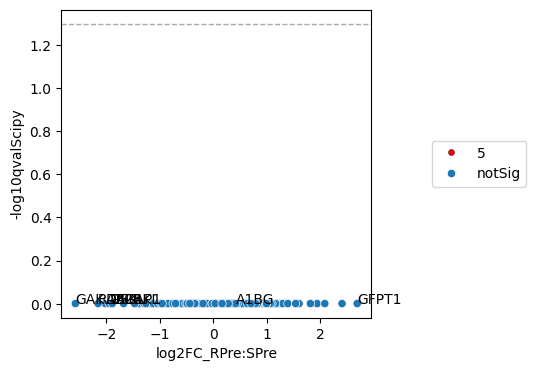

In [35]:
# make annotated volcano plot

diffExprGeneList = dfStats[dfStats['-log10qvalScipyRank'] < 1.301]['geneNamePrimary'].to_list()
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -1.5]['geneNamePrimary'].to_list())
diffExprGeneList.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 2.5]['geneNamePrimary'].to_list())

mask = dfStats['geneNamePrimary'].isin(diffExprGeneList)
annotations = diffExprGeneList

diffExprGeneListAlt = dfStats[dfStats['-log10qvalScipyRank'] < 15]['geneNamePrimary'].to_list()
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] < -5]['geneNamePrimary'].to_list())
diffExprGeneListAlt.extend(dfStats[dfStats['log2FC_RPre:SPre'] > 5]['geneNamePrimary'].to_list())

if len(diffExprGeneList) > 40:
    mask = dfStats['geneNamePrimary'].isin(diffExprGeneListAlt)
    annotations = diffExprGeneListAlt

plt.figure(figsize=(4,4))

sns.scatterplot(data = dfStats.loc[mask],
    x = 'log2FC_RPre:SPre',
    y = '-log10qvalScipy',
    size=5,
    facecolor = 'red',
    edgecolor = 'black',)

for i in annotations:
    plt.annotate(i,
        (dfStats[dfStats.geneNamePrimary == i]['log2FC_RPre:SPre'],
        dfStats[dfStats.geneNamePrimary == i]['-log10qvalScipy'],
        )
    ) 

sns.scatterplot(
    data=dfStats,
    x="log2FC_RPre:SPre",
    y="-log10qvalScipy",
    hue = 'sigFDR',
    ).axhline(
    1.3, color = 'darkgrey', linestyle = '--', linewidth=1)

plt.legend(bbox_to_anchor=(1.5, .5), loc='center right', borderaxespad=0)

plt.show()